In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_data(params, N=100):
    
    v = np.random.normal(size=N)
    w = np.random.normal(size=N)
    
    prm = ['A','B','C','D','G','H']
    A,B,C,D,G,H = [params[x] for x in prm]

    # assume r is lognormal
    r = np.random.lognormal(sigma=0.05, size=N) - 1
    
    x = np.zeros(N)
    y = np.zeros(N)

    for i in range(1,len(x)):
        x[i] = A*x[i-1] + B + G*v[i]
        y[i] = x[i] + D*r[i] + H*w[i]
        
    return x, y, r

In [3]:
true_params = {'A':0.9, 'B':0.005, 'C':1, 'D':0.1, 'G':0.0529, 'H':0.05}
np.random.seed(525)
x,y,r = generate_data(true_params, N=200)

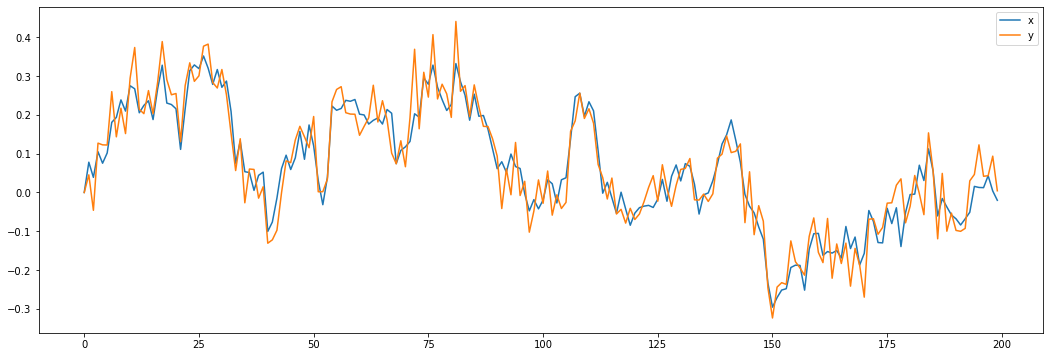

In [4]:
plt.figure(figsize=(18,6))
plt.plot(x, label='x')
plt.plot(y, label='y')
plt.legend()

In [5]:
def em_fit(y, r, init_params, num_iter=150, x_0=0, R_0=0.1):
    '''
    run Shumway Stoffer algorithm with given initial values
    
    Args:
        y (numpy.ndarray): input time series (difference in log returns)
        r (numpy.ndarray): input exogenous data (market return)
        init_params (dict): initial parameters for EM algorithm
        num_iter (int): maximum number of iterations for EM algorithm
        x_0 (float): initial value of state for Kalman filter
        R_0 (float): initial value of variance for Kalman filter
            
    Returns:
        dict: parameters (each parameter (key) is a list of all values from initial value until convergence)
        int: iteration at which the algorithm converged 
    '''
    
    N = len(y)
    A,B,C,D,G_sq,H_sq = [np.zeros(num_iter) for _ in range(6)]
    A[0],B[0],C[0],D[0],G_sq[0],H_sq[0] = (init_params['A'], init_params['B'], init_params['C'], 
                                     init_params['D'], init_params['G']**2, init_params['H']**2)
    
    # run algorithm for num_iter iterations
    for i in range(1,num_iter):
        
        # define matrices
        F = np.array([[A[i-1],0],[0,0]]) # state transition matrix
        G = np.array([[B[i-1],0],[0,1]]) # control matrix
        H = np.array([[1,D[i-1]]]) # observation matrix
        Q = np.array([[G_sq[i-1],0],[0,0.0001]]) # process noise matrix
        
        # define state and uncertainty
        z_0 = np.array([[x_0, r[0]]]).T
        P_0 = np.array([[R_0,0],[0,0]])

        # run Kalman filter
        z_pred = np.zeros([N,2,1])
        P_pred = np.zeros([N,2,2])

        for k in range(0,N):

            # predict
            if k==0:
                z_hat = F @ z_0 + G @ np.array([[1,r[k]]]).T
                P_hat = F @ P_0 @ F.T + Q
            else:
                z_hat = F @ z_pred[k-1] + G @ np.array([[1,r[k]]]).T
                P_hat = F @ P_pred[k-1] @ F.T + Q
            
            # update
            K = P_hat @ H.T @ np.linalg.inv(H @ P_hat @ H.T + H_sq[i-1])
            z_pred[k] = z_hat + K @ (y[k] - H @ z_hat)
            P_pred[k] = (np.eye(2) - K @ H) @ P_hat @ (np.eye(2) - K @ H).T + K * H_sq[i-1] @ K.T
            

        # run Kalman smoother
        z_N = np.zeros([N,2,1]) # smoothed state
        P_N = np.zeros([N,2,2]) # smoothed covariance
        J = np.zeros([N,2,2]) # backwards Kalman gain
        z_N[-1] = z_pred[-1] # initial smoothed state
        P_N[-1] = P_pred[-1] # initial smoothed covariance

        for k in range(N-2,-1,-1):
            J[k] = P_pred[k] @ F.T @ np.linalg.inv(F @ P_pred[k] @ F.T + Q)
            z_N[k] = z_pred[k] + J[k] @ (z_N[k+1] - (F @ z_pred[k] + G @ np.array([[1,r[k]]]).T))
            P_N[k] = P_pred[k] + J[k] @ (P_N[k+1] - (F @ P_pred[k] @ F.T + Q)) @ J[k].T
            
            
        # extract only spread and its variance
        x_N = z_N[:,0].flatten()
        R_N = P_N[:,0,0]
        K = K[0]
        
        # EM-algo
        P_11 = np.sum(R_N[1:] + x_N[1:]**2)
        P_00 = np.sum(R_N[:-1] + x_N[:-1]**2)
        # compute P_10
        sigma_kN = np.zeros(N)
        sigma_kN[-1] = A[i-1] * (1 - K) * P_pred[-1,0,0]
        for k in range(N-2,-1,-1):
            sigma_kN[k] = J[k,0,0] * P_pred[k+1,0,0] + J[k+1,0,0]*J[k,0,0] * (sigma_kN[k+1] - A[i-1] * P_pred[k+1,0,0])
        P_10 = np.sum(sigma_kN[1:] + x_N[1:] * x_N[:-1])
        
        # update parameters
        A[i] = (P_10 - 1/N * x_N[1:].sum() * x_N[:-1].sum()) / (P_00 - 1/N * (x_N[:-1]).sum() * (x_N[:-1]).sum())
        #A[i] = true_params['A']
        B[i] = (x_N[1:].sum() - A[i] * x_N[:-1].sum()) * 1/N
        #B[i] = true_params['B']
        #C[i] = (((y[1:] * x_N[1:]).sum() - (y[1:]*r[1:]).sum() / (r[1:]**2).sum() * (x_N[1:]*r[1:]).sum()) / 
        #        (P_11 - (x_N[1:]*r[1:]).sum() / (r[1:]**2).sum() * x_N[1:]*r[1:]).sum())
        C[i] = 1
        D[i] = ((y[1:] - x_N[1:]) * r[1:]).sum() / (r[1:]**2).sum()
        #D[i] = true_params['D']
        G_sq[i] = 1/N * (P_11 + A[i]**2 * P_00 + N*B[i]**2 - 2*P_10*A[i] - 2*(B[i]*x_N[1:]).sum() + 
                       (2*A[i]*x_N[:-1]*B[i]).sum())
        #G_sq[i] = true_params['G']**2
        H_sq[i] = 1/N * (R_N[1:].sum() + ((y[1:] - x_N[1:] - D[i]*r[1:])**2).sum())
        #H_sq[i] = true_params['H']**2
            
        # check convergence       
        S = abs(G_sq[i]-G_sq[i-1]) + abs(H_sq[i]-H_sq[i-1]) + abs(A[i]-A[i-1]) + abs(B[i]-B[i-1]) + abs(D[i]-D[i-1])
        if S<0.001:
            print('Converged at ', i)
            break
        
    return {'A':A, 'B':B, 'C':C, 'D':D, 'G':np.sqrt(G_sq), 'H':np.sqrt(H_sq)}, i

In [6]:
def plot_params(true_params, est_params):
    '''
    plot convergence for each parameter
    '''
    fig, axs = plt.subplots(3, 2, figsize=(18,12))
    fig.suptitle('EM algorithm covergence')
    for n,k in zip(np.arange(6), true_params.keys()):
        axs.flatten()[n].plot(np.arange(len(est_params[k])), est_params[k], label=f'Estimate of {k}')
        axs.flatten()[n].hlines(true_params[k], 0, len(est_params[k]), linestyle='dotted', 
                              color='r', label=f'True {k}')
        axs.flatten()[n].legend()
        axs.flatten()[n].set_xlim(left=0, right=len(est_params[k])-1)

In [7]:
x0 = 0
P0 = 0.1
A0 = 0.1
B0 = 0.1
C0 = 1
D0 = -0.2
G0 = 0.2
H0 = 0.1

max_iter = 1000

np.random.seed(525)
true_params = {'A':0.9, 'B':0.005, 'C':1, 'D':0.1, 'G':0.0529, 'H':0.05}
x,y,r = generate_data(true_params, N=500)
init_params = {'A':A0, 'B':B0, 'C':C0, 'D':D0, 'G':G0, 'H':H0}
est_params, i = em_fit(y, r, init_params, num_iter=max_iter)

Converged at  14


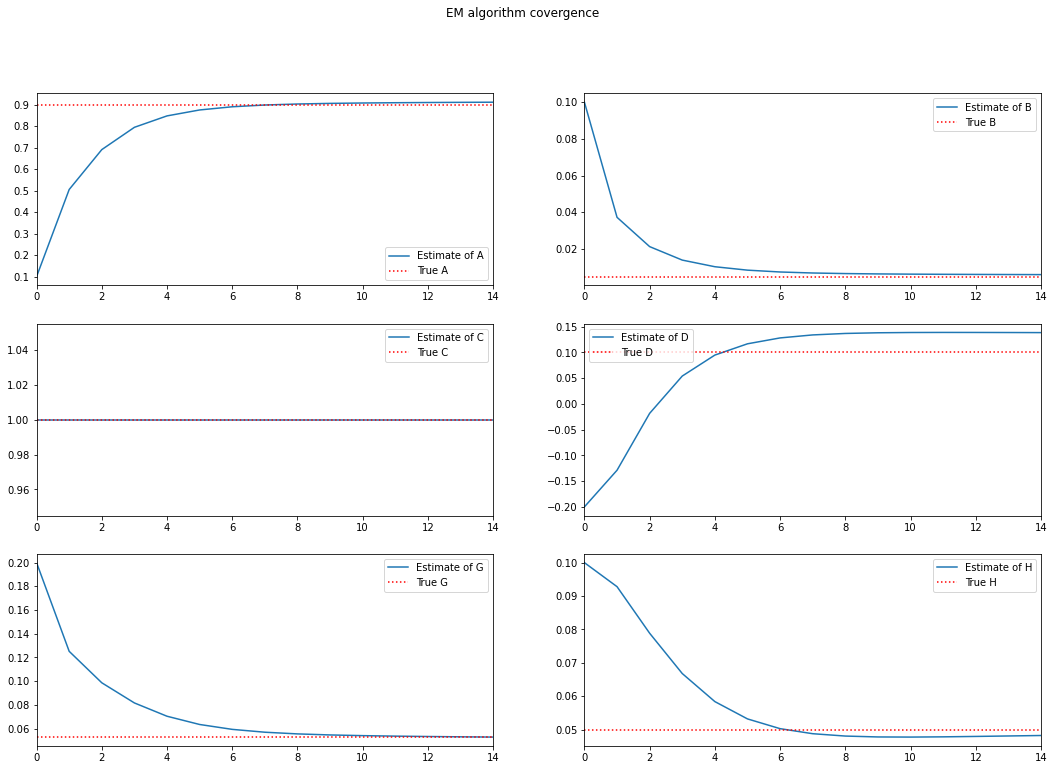

In [8]:
params = ['A','B','C','D','G','H']

for p in params:
    est_params[p] = est_params[p][:i+1]
    
plot_params(true_params, est_params)

# Backtest

In [9]:
prices = pd.read_csv('vbr100_10_13.csv', index_col=0)
prices = prices.loc['2010-07-01':]
log_prices = np.log(prices).dropna(axis=1)
log_returns = log_prices.diff().dropna()
log_returns_train = log_returns.loc[:'2012-06-30']
log_returns_test = log_returns.loc['2012-07-01':]
log_prices_train = log_prices.loc[log_returns_train.index]

In [10]:
import yfinance as yf
market_price = yf.download('VBR', start='2010-07-01', end='2012-12-31')['Adj Close']
market_logret = np.log(market_price).diff().dropna()

[*********************100%***********************]  1 of 1 completed


In [11]:
market_logret

Date
2010-07-02   -0.009765
2010-07-06   -0.012343
2010-07-07    0.036026
2010-07-08    0.014636
2010-07-09    0.015320
                ...   
2012-12-21   -0.005747
2012-12-24   -0.004769
2012-12-26   -0.005541
2012-12-27   -0.001251
2012-12-28   -0.007398
Name: Adj Close, Length: 628, dtype: float64

In [12]:
log_returns

,TRN,BDN,CMC,NYT,LEG,VNO,HLX,ORI,HP,EQC,...,M,ON,GPS,X,MRO,XRX,JNPR,CAR,RAD,SLM
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-02,-0.005144,-0.017934,-0.027356,-0.016336,-0.006641,-0.025676,-0.076551,-0.004971,0.001643,-0.015364,...,-0.026536,-0.014162,-0.016293,-0.012665,-0.000648,0.002506,0.045888,-0.052001,-0.010811,0.002903
2010-07-06,-0.018508,-0.048790,-0.017586,0.008202,-0.009269,-0.023183,-0.039019,0.001660,0.012514,-0.058865,...,-0.024959,0.000000,-0.005663,0.014760,0.005821,-0.010063,0.000415,-0.052555,-0.044452,-0.002903
2010-07-07,0.047872,0.025668,0.036425,-0.003507,0.047483,0.047213,0.041031,0.044596,0.072466,0.059261,...,0.028314,0.050976,0.017907,0.055223,0.032675,0.026202,0.056489,0.077301,0.011299,0.052843
2010-07-08,0.010518,-0.011765,0.030631,0.045775,0.007373,0.007248,0.025795,0.003167,0.006516,-0.024098,...,0.029163,0.007502,-0.079113,0.017183,0.001248,0.006139,-0.002356,0.088427,0.065241,0.023616
2010-07-09,0.025015,0.037741,0.031183,0.007799,0.010716,0.021700,0.019399,0.015687,0.010437,0.010916,...,0.004869,0.008929,0.016871,0.042641,0.000000,0.006101,0.013282,0.038173,0.020834,0.014261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-21,-0.002517,-0.009950,-0.002670,-0.018370,-0.024301,-0.004878,-0.002937,-0.027347,-0.009700,-0.001851,...,-0.010607,-0.015954,-0.012041,-0.028008,-0.013118,-0.011284,-0.008884,-0.006424,0.016394,0.000000
2012-12-24,-0.003928,-0.001668,0.002670,-0.017535,-0.004483,-0.000376,-0.004914,0.007619,-0.007650,-0.002474,...,0.000267,-0.005865,0.000000,0.005000,-0.011662,-0.009979,-0.007964,-0.002482,0.063013,-0.001785
2012-12-26,-0.000562,0.000000,-0.002002,-0.017847,-0.001124,-0.006670,0.002460,0.009443,-0.004474,-0.001859,...,-0.010449,0.013148,-0.031409,0.008278,-0.007194,-0.011527,-0.006015,-0.022111,0.073563,-0.003580


In [14]:
market_logret.index = log_returns.index # to have indexes in the same format

In [15]:
market_train = market_logret.loc[log_returns_train.index]

In [16]:
# perform Johansen for each pair of stocks
from statsmodels.tsa.vector_ar.vecm import coint_johansen

pairs_johansen = []

for s1 in log_prices_train.columns:
    for s2 in log_prices_train.columns:
        if (s1!=s2) and (f'{s2}-{s1}' not in pairs_johansen):
            res = coint_johansen(log_prices_train[[s1,s2]], det_order=0, k_ar_diff=1)
            if np.sum(res.lr2 > res.cvm[:,-2]) == 2: # null rejected at 95% level
                #print(pair)
                pairs_johansen.append(f'{s1}-{s2}')

In [17]:
len(pairs_johansen)

153

In [18]:
def parse_pair(pair):
    s1 = pair[:pair.find('-')]
    s2 = pair[pair.find('-')+1:]
    return s1,s2

parameters_df = pd.DataFrame(index=pairs_johansen, columns=['A','B','D','G','H'])
init_params = {'A':0.5, 'B':0, 'C':1, 'D':0, 'G':0.1, 'H':0.1}
max_iter = 1000

for pair in pairs_johansen:
    s1,s2 = parse_pair(pair)
    print(f'Processing pair {pair} ...')
    
    spread = log_returns_train[s1] - log_returns_train[s2]
    parameters, i = em_fit(spread, market_train, init_params, num_iter=max_iter)
    if i<max_iter-1: # if converged
        parameters_df.loc[pair] = [parameters[p][i] for p in parameters_df.columns]

Processing pair TRN-LEG ...
Converged at  49
Processing pair TRN-WSM ...
Converged at  53
Processing pair TRN-WEN ...
Converged at  42
Processing pair TRN-MRO ...
Converged at  50
Processing pair BDN-LEG ...
Converged at  129
Processing pair BDN-PWR ...
Converged at  24
Processing pair BDN-TGNA ...
Converged at  12
Processing pair CMC-VNO ...
Converged at  146
Processing pair CMC-AGCO ...
Converged at  19
Processing pair CMC-URBN ...
Converged at  54
Processing pair CMC-LNC ...
Converged at  19
Processing pair CMC-WEN ...
Converged at  129
Processing pair NYT-VNO ...
Converged at  31
Processing pair NYT-AGCO ...
Converged at  20
Processing pair NYT-VSH ...
Converged at  17
Processing pair NYT-UIS ...
Converged at  13
Processing pair NYT-WEN ...
Converged at  105
Processing pair NYT-PTEN ...
Converged at  10
Processing pair NYT-MOS ...
Converged at  17
Processing pair NYT-CLF ...
Converged at  21
Processing pair LEG-VNO ...
Converged at  22
Processing pair LEG-HP ...
Converged at  129
P

In [19]:
# select only pairs with positive A
good_pairs_df = parameters_df[parameters_df['A']>0]
good_pairs_df

,A,B,D,G,H
BDN-LEG,0.52236,0.000076,0.131299,0.008002,0.014198
BDN-PWR,0.093116,0.000139,0.044262,0.014189,0.014388
BDN-TGNA,0.008444,0.000248,-0.12403,0.016316,0.016554
NYT-UIS,0.020704,-0.000362,0.014834,0.025558,0.025655
NYT-PTEN,0.020376,-0.000508,0.130993,0.021013,0.021201
...,...,...,...,...,...
WEN-NOV,0.023507,-0.000678,-0.421771,0.015668,0.017477
WEN-CAR,0.031475,-0.000207,-0.681047,0.017715,0.022148
STLD-DVN,0.116812,-0.000233,0.355536,0.008655,0.015231
APA-CLF,0.05837,0.000256,-0.500335,0.011058,0.018176


In [20]:
# calculate parameters of Vasicek process
good_pairs_df['log_A'] = np.log(good_pairs_df['A'].astype(float))
good_pairs_df[r'$\theta$'] = good_pairs_df['B'] / (1 - good_pairs_df['A'])
good_pairs_df[r'$\kappa$'] = -good_pairs_df['log_A']
good_pairs_df[r'$\sigma$'] = np.sqrt((good_pairs_df['G']**2 * 2 * good_pairs_df[r'$\kappa$'] / 
                                     (1 - np.exp(-2 * good_pairs_df[r'$\kappa$']))).astype(float))

/tmp/ipykernel_5844/926495703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_pairs_df['log_A'] = np.log(good_pairs_df['A'].astype(float))
/tmp/ipykernel_5844/926495703.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_pairs_df[r'$\theta$'] = good_pairs_df['B'] / (1 - good_pairs_df['A'])
/tmp/ipykernel_5844/926495703.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [21]:
good_pairs_df.sort_values(by=r'$\kappa$', ascending=False)

,A,B,D,G,H,log_A,$\theta$,$\kappa$,$\sigma$
WSM-NOV,0.002259,-0.000387,-0.254513,0.017388,0.018273,-6.092949,-0.000387,6.092949,0.060700
TGNA-SNV,0.002326,0.000763,-0.230465,0.020547,0.021386,-6.063445,0.000765,6.063445,0.071552
WEN-KSS,0.00424,0.000405,0.063245,0.014773,0.014841,-5.463158,0.000407,5.463158,0.048834
WSM-MRO,0.005435,0.00013,-0.140037,0.017795,0.018036,-5.214871,0.000131,5.214871,0.057471
LEG-GT,0.0078,0.00033,-0.52741,0.014889,0.017967,-4.853608,0.000333,4.853608,0.046391
...,...,...,...,...,...,...,...,...,...
LEG-ENDP,0.377521,-0.000262,0.201137,0.009775,0.016399,-0.974129,-0.000421,0.974129,0.014734
LEG-HP,0.391419,0.000118,-0.289369,0.008415,0.018612,-0.937976,0.000193,0.937976,0.012525
VNO-ORI,0.433655,0.000529,0.100008,0.010198,0.014117,-0.835506,0.000933,0.835506,0.014629
VNO-KBH,0.499884,0.000446,-0.657103,0.010387,0.02563,-0.693379,0.000892,0.693379,0.014124


In [22]:
selected_pairs = []
selected_stocks = []

for pair in good_pairs_df.sort_values(by=r'$\kappa$', ascending=False).index:
    s1,s2 = parse_pair(pair)
    if (s1 not in selected_stocks) and (s2 not in selected_stocks):
        selected_pairs.append(pair)
        selected_stocks.append(s1)
        selected_stocks.append(s2)
    
    if len(selected_pairs)>=5:
        break

In [23]:
good_pairs_df.loc[selected_pairs]

,A,B,D,G,H,log_A,$\theta$,$\kappa$,$\sigma$
WSM-NOV,0.002259,-0.000387,-0.254513,0.017388,0.018273,-6.092949,-0.000387,6.092949,0.060700
TGNA-SNV,0.002326,0.000763,-0.230465,0.020547,0.021386,-6.063445,0.000765,6.063445,0.071552
WEN-KSS,0.00424,0.000405,0.063245,0.014773,0.014841,-5.463158,0.000407,5.463158,0.048834
LEG-GT,0.0078,0.00033,-0.52741,0.014889,0.017967,-4.853608,0.000333,4.853608,0.046391
ENDP-UIS,0.009353,0.000841,-0.629924,0.021324,0.026703,-4.672078,0.000849,4.672078,0.065186


In [24]:
W = 500 # window size
P = 5 # max lag parameter
max_iter = 1000

positions_main = pd.DataFrame(index=log_returns_test.index, columns=selected_stocks)
positions_base = pd.DataFrame(index=log_returns_test.index, columns=selected_stocks)

for t in positions_main.index:
    # prepare data
    log_prices_tmp = log_prices.loc[:t]
    log_prices_tmp = log_prices_tmp.iloc[-W:]
    log_returns_tmp = log_returns.loc[:t]
    log_returns_tmp = log_returns_tmp.iloc[-W:]
    market_tmp = market_logret.loc[log_returns_tmp.index]
       
    for pair in selected_pairs:
        s1,s2 = parse_pair(pair)
        
        spread = log_returns_tmp[s1] - log_returns_tmp[s2]
        
        parameters,i = em_fit(spread, market_tmp, init_params, num_iter=max_iter)
        A,B,D,G,H = [parameters[p][i] for p in ['A','B','D','G','H']]
        theta = B / (1 - A)
        true_spread = spread - D * market_tmp
        
        # calculate cumulative sums
        spread = spread.rolling(P).sum()
        true_spread = true_spread.rolling(P).sum()
        
        # positions for baseline strategy
        if spread.iloc[-1] > 0:
            positions_base.loc[t, [s1,s2]] = [-1,1] # short position
        else:
            positions_base.loc[t, [s1,s2]] = [1,-1] # long position
            
        # positions for the main algorithm
        if true_spread.iloc[-1] > theta:
            positions_main.loc[t, [s1,s2]] = [-1,1] # short position
        else:
            positions_main.loc[t, [s1,s2]] = [1,-1] # long positions

Converged at  12
Converged at  11
Converged at  14
Converged at  10
Converged at  16
Converged at  12
Converged at  11
Converged at  15
Converged at  10
Converged at  16
Converged at  12
Converged at  11
Converged at  17
Converged at  10
Converged at  16
Converged at  12
Converged at  12
Converged at  16
Converged at  11
Converged at  16
Converged at  13
Converged at  9
Converged at  15
Converged at  11
Converged at  16
Converged at  13
Converged at  15
Converged at  15
Converged at  11
Converged at  17
Converged at  13
Converged at  9
Converged at  16
Converged at  11
Converged at  16
Converged at  13
Converged at  9
Converged at  15
Converged at  10
Converged at  16
Converged at  13
Converged at  9
Converged at  14
Converged at  12
Converged at  16
Converged at  14
Converged at  8
Converged at  13
Converged at  12
Converged at  17
Converged at  15
Converged at  7
Converged at  13
Converged at  10
Converged at  16
Converged at  13
Converged at  15
Converged at  13
Converged at  12
Con

In [25]:
returns_test = prices.pct_change().loc[positions_base.index, positions_base.columns]
ret_main = (positions_main.shift() * returns_test).sum(axis=1) / 5 * 2
ret_base = (positions_base.shift() * returns_test).sum(axis=1) / 5 * 2
cumret_main = np.nancumprod(ret_main + 1)
cumret_base = np.nancumprod(ret_base + 1)

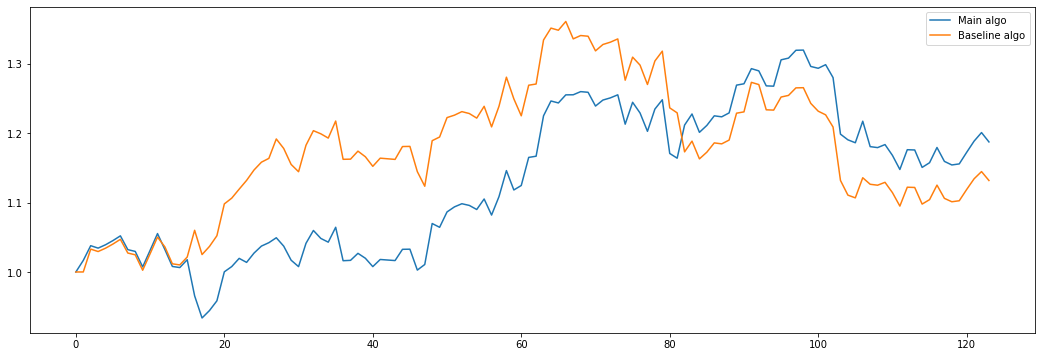

In [27]:
plt.figure(figsize=(18,6))
plt.plot(cumret_main, label='Main algo')
plt.plot(cumret_base, label='Baseline algo')
plt.legend()

In [26]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

In [32]:
metrics_df = pd.DataFrame(index=['Total return', 'APR', 'Sharpe ratio', 'Max Drawdown', 'Max Drawdown Duration'], 
             columns=['Baseline algo', 'Main algo'])
metrics_df['Baseline algo'] = calculate_metrics(cumret_base)
metrics_df['Main algo'] = calculate_metrics(cumret_main)
metrics_df

,Baseline algo,Main algo
Total return,0.131894,0.187502
APR,0.286314,0.418001
Sharpe ratio,0.945080,1.268063
Max Drawdown,-0.195532,-0.130415
Max Drawdown Duration,57.000000,25.000000


In [33]:
# Calculate Kendall's tau for each pair of stocks
from scipy import stats

results_tau = pd.DataFrame(columns=['tau'])

for s1 in log_returns_train.columns:
    for s2 in log_returns_train.columns:
        if (s1!=s2) and (f'{s2}-{s1}' not in results_tau.index):
            results_tau.loc[f'{s1}-{s2}'] = stats.kendalltau(log_returns_train[s1], log_returns_train[s2])[0]

In [48]:
results_tau.sort_values(by='tau', ascending=False)

,tau
STLD-X,0.620246
UNM-LNC,0.619956
VNO-AIV,0.617863
APA-DVN,0.599782
IVZ-LNC,0.593429
...,...
HFC-MFA,0.168235
KSS-RIG,0.166729
GME-RIG,0.159435
NVAX-WEN,0.147589


In [38]:
selected_pairs = []
selected_stocks = []

for pair in results_tau.sort_values(by='tau', ascending=False).index:
    s1,s2 = parse_pair(pair)  
    if (s1 not in selected_stocks) and (s2 not in selected_stocks):
        res = coint_johansen(log_prices_train[[s1,s2]], det_order=0, k_ar_diff=1)
        if np.sum(res.lr2 > res.cvm[:,-2]) == 2: # null rejected at 95% level
            selected_pairs.append(pair)
            selected_stocks.append(s1)
            selected_stocks.append(s2)
    if len(selected_pairs)>=5:
        break

In [39]:
selected_pairs

['MUR-APA', 'VNO-LNC', 'IVZ-IPG', 'HLX-NOV', 'LEG-HOG']

In [40]:
W = 500 # window size
P = 5 # max lag parameter
max_iter = 1000

positions_bp = pd.DataFrame(index=log_returns_test.index, columns=selected_stocks)

for t in positions_bp.index:
    # prepare data
    log_prices_tmp = log_prices.loc[:t]
    log_prices_tmp = log_prices_tmp.iloc[-W:]
    log_returns_tmp = log_returns.loc[:t]
    log_returns_tmp = log_returns_tmp.iloc[-W:]
       
    for pair in selected_pairs:
        s1,s2 = parse_pair(pair)
        
        res = coint_johansen(log_prices_tmp[[s1,s2]], det_order=0, k_ar_diff=1)
        max_eval = res.ind[0] # maximum eigenvalue index
        b = res.evec[:,max_eval] # cointegration vector
        
        spread = (b * log_returns_tmp[[s1,s2]]).sum(axis=1)
        spread = spread.rolling(P).sum()
        
        # positions for baseline strategy
        if spread.iloc[-1] > 0:
            positions_bp.loc[t, [s1,s2]] = [-1,1] # short position
        else:
            positions_bp.loc[t, [s1,s2]] = [1,-1] # long position

In [44]:
ret_bp = (positions_bp.shift() * returns_test).sum(axis=1) / 5 * 2
cumret_bp = np.nancumprod(ret_bp + 1)

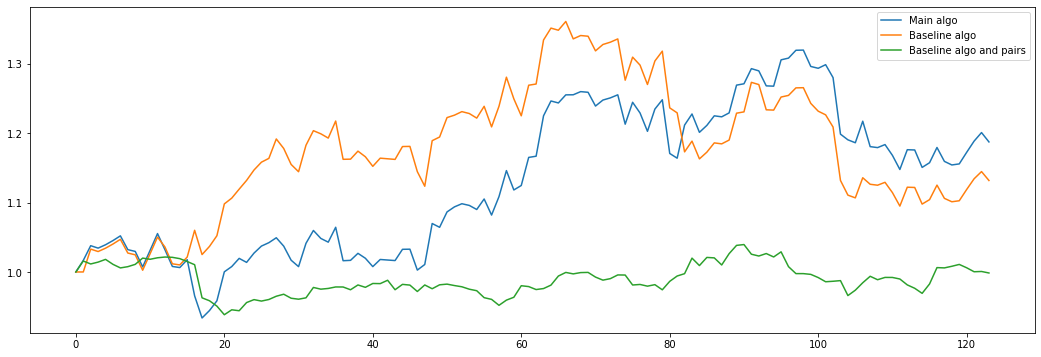

In [47]:
plt.figure(figsize=(18,6))
plt.plot(cumret_main, label='Main algo')
plt.plot(cumret_base, label='Baseline algo')
plt.plot(cumret_bp, label='Baseline algo and pairs')
plt.legend()

In [45]:
metrics_df['Baseline algo and pairs'] = calculate_metrics(cumret_bp)

In [46]:
metrics_df

,Baseline algo,Main algo,Baseline algo and pairs
Total return,0.131894,0.187502,-0.001442
APR,0.286314,0.418001,-0.002927
Sharpe ratio,0.945080,1.268063,0.049349
Max Drawdown,-0.195532,-0.130415,-0.081422
Max Drawdown Duration,57.000000,25.000000,75.000000
